In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [30]:
data = pd.read_csv("communities.csv")
data = data.replace('?', np.NaN)
data_to_use = data.drop(columns=[' state ', ' county ', ' community ', ' communityname string', ' fold '])
print(np.sum(data_to_use.isna()))
print(data_to_use.shape)

 population                 0
 householdsize              0
 racepctblack               0
 racePctWhite               0
 racePctAsian               0
                         ... 
 LemasPctPolicOnPatr     1675
 LemasGangUnitDeploy     1675
 LemasPctOfficDrugUn        0
 PolicBudgPerPop         1675
 ViolentCrimesPerPop        0
Length: 123, dtype: int64
(1994, 123)


In [31]:
# Data Cleaning process
threshold = 700
columns_to_remove = []
for column in data_to_use.columns.values:
    if np.sum(data_to_use[column].isna()) > threshold:
        # add this column to the list that should be removed
        columns_to_remove.append(column)
        
print(columns_to_remove)
print(len(columns_to_remove))
# now lets remove them
data_filtered_cols = data_to_use.drop(columns_to_remove, axis=1)
print(data_filtered_cols.shape)
data_filtered = data_filtered_cols.dropna()
data_filtered = data_filtered.convert_dtypes()
display(data_filtered.dtypes)

[' LemasSwornFT ', ' LemasSwFTPerPop ', ' LemasSwFTFieldOps ', ' LemasSwFTFieldPerPop ', ' LemasTotalReq ', ' LemasTotReqPerPop ', ' PolicReqPerOffic ', ' PolicPerPop ', ' RacialMatchCommPol ', ' PctPolicWhite ', ' PctPolicBlack ', ' PctPolicHisp ', ' PctPolicAsian ', ' PctPolicMinor ', ' OfficAssgnDrugUnits ', ' NumKindsDrugsSeiz ', ' PolicAveOTWorked ', ' PolicCars ', ' PolicOperBudg ', ' LemasPctPolicOnPatr ', ' LemasGangUnitDeploy ', ' PolicBudgPerPop ']
22
(1994, 101)


 population              Float64
 householdsize           Float64
 racepctblack            Float64
 racePctWhite            Float64
 racePctAsian            Float64
                          ...   
 LandArea                Float64
 PopDens                 Float64
 PctUsePubTrans          Float64
 LemasPctOfficDrugUn     Float64
 ViolentCrimesPerPop     Float64
Length: 101, dtype: object

In [32]:
print(data_filtered.iloc[:,:])

       population    householdsize    racepctblack    racePctWhite   \
0             0.19             0.33            0.02             0.9   
1              0.0             0.16            0.12            0.74   
2              0.0             0.42            0.49            0.56   
3             0.04             0.77             1.0            0.08   
4             0.01             0.55            0.02            0.95   
...            ...              ...             ...             ...   
1989          0.01              0.4             0.1            0.87   
1990          0.05             0.96            0.46            0.28   
1991          0.16             0.37            0.25            0.69   
1992          0.08             0.51            0.06            0.87   
1993           0.2             0.78            0.14            0.46   

       racePctAsian    racePctHisp    agePct12t21    agePct12t29   \
0               0.12           0.17           0.34           0.47   
1        

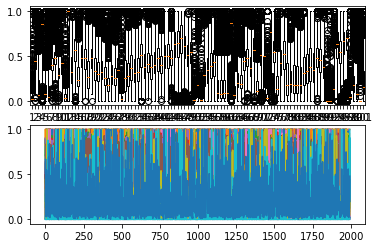

In [33]:
# data_filtered.plot.box(title="Box and whisker plot", grid=True)
data_filtered = data_filtered.astype(float)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(data_filtered.transpose())
ax = fig.add_subplot(2, 1, 2)
ax.plot(data_filtered)
plt.show()

In [34]:
data_filtered.reset_index(inplace=True, drop=True)

In [35]:
y = data_filtered[" ViolentCrimesPerPop "]
X = data_filtered.drop([" ViolentCrimesPerPop "], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1195, 100)
X_val shape: (399, 100)
X_test shape: (399, 100)


In [36]:
# OLS version
model = sm.OLS(Y_train, X_train)
trained_model = model.fit()
print(trained_model.summary())

                                  OLS Regression Results                                  
Dep. Variable:      ViolentCrimesPerPop    R-squared (uncentered):                   0.861
Model:                               OLS   Adj. R-squared (uncentered):              0.849
Method:                    Least Squares   F-statistic:                              67.99
Date:                   Tue, 06 Apr 2021   Prob (F-statistic):                        0.00
Time:                           14:37:24   Log-Likelihood:                          801.57
No. Observations:                   1195   AIC:                                     -1403.
Df Residuals:                       1095   BIC:                                     -894.6
Df Model:                            100                                                  
Covariance Type:               nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975

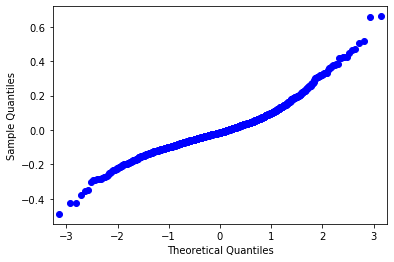

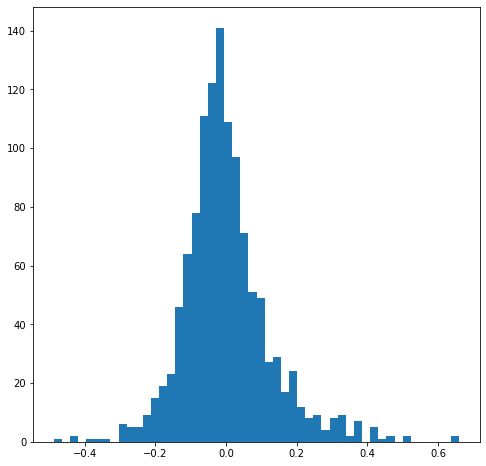

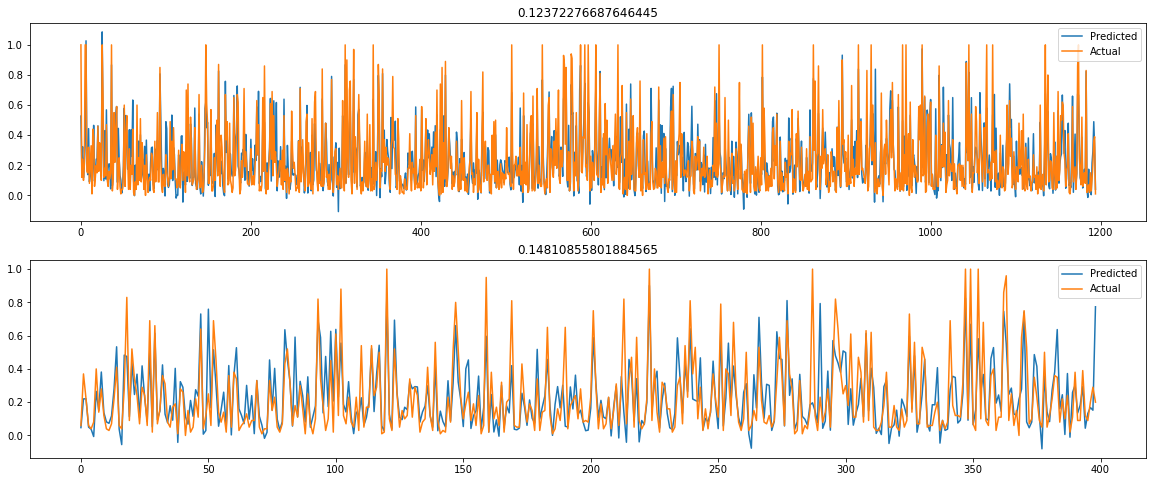

In [37]:
f = sm.qqplot(trained_model.resid)
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.hist(trained_model.resid, 50)

y_train_pred = trained_model.predict(X_train.astype(float))
y_test_pred = trained_model.predict(X_test.astype(float))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(y_train_pred)), y_train_pred, label='Predicted')
ax.plot(np.arange(len(y_train_pred)), y_train.astype(float), label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(y_test_pred)), y_test_pred, label='Predicted')
ax.plot(np.arange(len(y_test_pred)), y_test.astype(float), label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [38]:
# Fit to Regression model
model_sk = LinearRegression(fit_intercept = False).fit(X = X_train.to_numpy(), y = y_train.to_numpy())
print(model_sk.coef_)
print(model_sk.score(X_train.to_numpy(), y_train.to_numpy()))

[ 0.49198548  0.06328822  0.21098181 -0.02195918  0.05091358  0.03881359
  0.20206361 -0.12186704 -0.20360536  0.25594055 -0.55879413  0.05417517
 -0.29043132 -0.18654952  0.03928884 -0.13492306  0.05750657  0.05093048
 -0.07476393  0.35010089  0.24149733 -0.45159887 -0.02493657 -0.02842529
  0.05032477  0.03610106  0.04382478 -0.09862953 -0.14323986  0.00850184
 -0.08572037 -0.02781275  0.04748329  0.42858975 -0.03991075 -0.03162662
  0.03882825  0.16154993  0.22419279  0.21666076 -0.14108305 -0.03476421
 -0.06797359 -0.05316204 -0.25693544  0.03622483 -0.00668306  0.0262685
 -0.18066806 -0.18200626  0.25507293 -0.10795392 -0.03742166  0.1348626
 -0.05803981  0.0423366   0.07984789 -0.19189113  0.02697158  0.020363
 -0.05965655 -0.20677796 -0.21833251 -0.0430851   0.70890163 -0.34103707
 -0.07099108  0.21812406  0.38741721  0.15981754  0.06400707  0.33792522
  0.01764975 -0.21877328  0.05255416 -0.04775391 -0.03624971  0.02070514
 -0.00314389 -0.11478999 -0.05686369  0.08776463 -0.248

Text(0.5, 1.0, 'Testing Data')

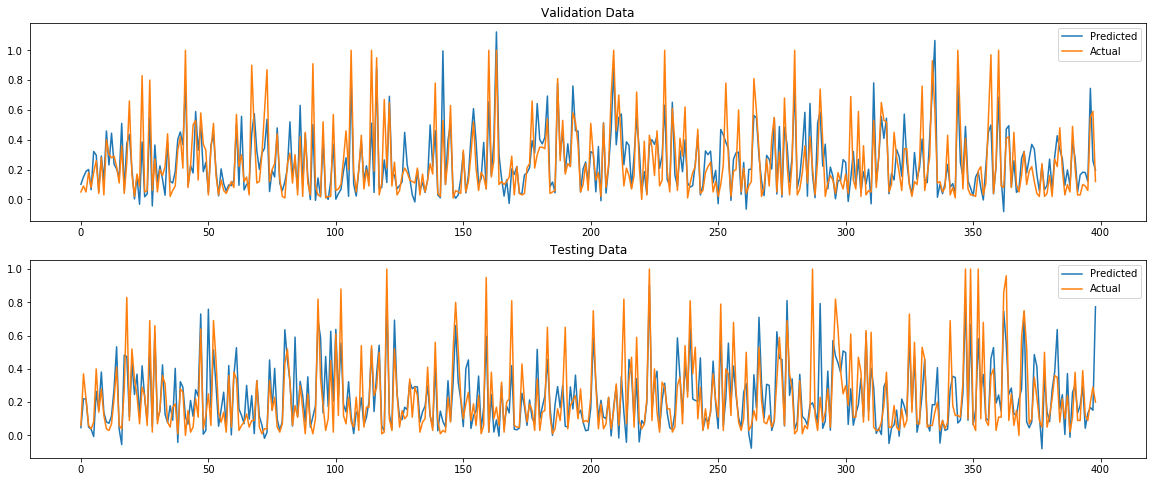

In [39]:
#The plot is gonna give the same result as the OLS method used above.
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(model_sk.predict(X_val), label='Predicted')
ax.plot(y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data')
ax = fig.add_subplot(2, 1, 2)
ax.plot(model_sk.predict(X_test), label='Predicted')
ax.plot(y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data')

In [40]:
def standardise(data):
  """ Standardise/Normalise data to have zero mean and unit variance

  Args:
    data (np.array):
      data we want to standardise (usually covariates)

    Returns:
      Standardised data, mean of data, standard deviation of data
  """
  mu = np.mean(data, axis=0)
  sigma = np.std(data, axis=0)
  scaled = (data - mu) / sigma
  return scaled, mu, sigma

In [41]:
X_train_std, mu_train_x, sigma_train_x = standardise(X_train)
Y_train_std, mu_train_y, sigma_train_y = standardise(y_train)
X_val_std = (X_val - mu_train_x)/sigma_train_x
Y_val_std = (y_val - mu_train_y)/sigma_train_y
X_test_std = (X_test - mu_train_x)/sigma_train_x
Y_test_std = (y_test - mu_train_y)/sigma_train_y
print(mu_train_x)


 population              0.055916
 householdsize           0.464067
 racepctblack            0.180243
 racePctWhite            0.751983
 racePctAsian            0.153916
                           ...   
 PctSameState85          0.657255
 LandArea                0.065858
 PopDens                 0.229598
 PctUsePubTrans          0.160109
 LemasPctOfficDrugUn     0.092385
Length: 100, dtype: float64


In [42]:
def rmse(actual, pred):
  return np.sqrt(mean_squared_error(actual, pred))

def r_squared(actual, predicted):
  r2 = r2_score(actual, predicted)
  return r2

def adj_r2(actual, predicted, n, p):
  r2 = r2_score(actual, predicted)
  adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1);
  return adjr2

def evaluate_regularisation(x_train, y_train, x_val, y_val, x_test, y_test,
                            response_mu, response_sigma, alpha_list, L1_L2):
  """
  Evaluates the efficacy of regularisation for a linear model.
  
  Identifies which values regression coffections and values of alpha
  (the hyperparam for the strength of regularisation) offers the
  best performance on the validation set.

  Evaluation is required to be performed on the standardised data, to allow
  for ease of comparison (where standardised here refers to normalisation,
  such that the data has a mean of zero and a std. of one.) This will show
  
  Will display the coefficients used in the NORMALISED/STANDARDISED model 
  used to achieve the best results.

  Is able to evaluate both Ridge and Lasso regularisation (and Elasticnet
  really if you want to try it, but in this class we are sticking to Ridge
  and Lasso).

  Args:
    x_train (np.array):
      normalised predictor variable training data
    y_train (np.array):
      normalised response variable training data
    x_val (np.array):
      normalised predictor variable validation data
    y_val (np.array):
      normalised response variable validation data
    x_test (np.array):
      normalised predictor variable test data
    y_test (np.array):
      normalised response variable test data
    response_mu (np.array):
      the mean value of the response variable from the TRAINING data
    response_sigma (np.array):
      the standard deviation  of the response variable from the TRAINING data
    alpha_list (list[np.float]):
      proposed values for alpha (the regularisation hyper param, also called
      lambda in other texts and in the lectures). Each value must be greater
      than zero.
    L1_L2 (np.int):
      Boolean to say whether we want to perform Ridge or Lasso regularisation.
      When zero, will be Ridge, When one, will be Lasso.
      Note: this value can actually be a float between zero and one as well 
      if you want to try Elasticnet regression, but here in this class would
      recommend sticking to just Ridge and Lasso.

  Retuns:
    NA
  """
  # Ridge: L1_L2 = 0
  # Lasso: L1_L2 = 1
  # create the model
  model = sm.OLS(y_train, x_train)
  # initialise the value for best RMSE that is obnoxiously large, as we want this be 
  # overwritten each time RMSE is smaller, since smaller is better and we want to 
  # update our best models each time the RMSE is smaller.
  best_rmse = 10e12
  best_alpha = []
  rmse_val = []
  rmse_train = []
  best_coeffs = []
  for alpha in alpha_list:
    model_cross_fit = model.fit_regularized(alpha=alpha, L1_wt=L1_L2)
    train_pred = model_cross_fit.predict(x_train)
    val_pred = model_cross_fit.predict(x_val)
    # want to append the rmse value to a list, as will plot all values later on
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, val_pred)))
    # if this is the model with the lowest RMSE, lets save it
    # the [-1] index says get the last value from the list (which is the most recent RMSE)
    if rmse_val[-1] < best_rmse:
      best_rmse = rmse_val[-1]
      best_alpha = alpha
      best_coeffs = model_cross_fit.params
      
  print('Best values on Validation Data set')
  # extract the gradient and the bias from the coefficients
  # The reshape will make sure the slope is a column vector
  slope = np.array(best_coeffs[0:]).reshape(-1, 1)
  # the intercept coefficient is the last index variable, which was included with the
  # sm.add_constant() method
  # use the @ operator to perform vector/matrix multiplication
  pred_val_rescaled = (x_val @ slope) * response_sigma + response_mu
  pred_train_rescaled = (x_train @ slope) * response_sigma + response_mu
  best_r2 = r_squared(y_train * response_sigma + response_mu, pred_train_rescaled)
  best_adj_r2 = adj_r2(y_train * response_sigma + response_mu, pred_train_rescaled,
                           x_train.shape[0], x_train.shape[1]) 
  best_val_rmse = np.sqrt(mean_squared_error(y_val* response_sigma + response_mu, pred_val_rescaled))
  print('Best R Squared = {}'.format(best_r2))
  print('Best Adjusted = {}'.format(best_adj_r2))
  print('Best RMSE (val) = {}'.format(best_val_rmse))
  print('Best coefficients on the normalised model')
  print('Best slope = {}'.format(slope))
  
  # now plotting some data
  fig, axs = plt.subplots(4, figsize=(20, 25))
  # plot the first values of alpha vs RMSE for train and validation data    
  axs[0].plot(np.array(alpha_list), rmse_train)
  axs[0].plot(np.array(alpha_list), rmse_val)
  axs[0].legend(['Training', 'Validation'])
  axs[0].set_title('RMSE vs Lambda')
  axs[0].set_xlabel('Lambda')
  axs[0].set_ylabel('RMSE')    
  # plot prediction and true values for test set
  axs[1].plot((y_test*response_sigma + response_mu))
  axs[1].plot((x_test @ slope) * response_sigma + response_mu)
  axs[1].legend(['Actual', 'Predicted'])
  axs[1].set_title('Test Set Performance')
  # plotting the Q-Q plot
  train_pred = (x_train @ slope).reshape(y_train.shape)
  resid = y_train - train_pred
  sm.qqplot(resid, ax=axs[2], line='s')
  axs[2].set_title('Q-Q Plot for Linear Regression')
  # plot the residuals as well
  axs[3].scatter(train_pred, resid)
  axs[3].set_title('Residuals for training set')
  axs[3].set_xlabel('Predicted')
  axs[3].set_ylabel('Residuals')



In [ ]:
#Ridge
alpha_list = np.linspace(0, 10.0, 1000)
evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 0)


In [ ]:
#Laso
alpha_list = np.linspace(0, 1.0, 1000)
evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 1)